In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import math

In [2]:
import numpy as np
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Creemos embeddings de prueba que reprenten dos palabras que insertaremos en el código. Hagamos que tengan las dimensiones de BERT: 768 features.

In [3]:
embedding_palabras = torch.rand((3,768))*0.1
embedding_palabras.shape

torch.Size([3, 768])

Creamos las matrices de pesos que nos darán nuestros vectores query, key y value.

In [4]:
w_query = torch.rand((768, 768))*0.1
w_key = torch.rand((768, 768))*0.1
w_value = torch.rand((768, 768))*0.1

Creamos la constante de las dimensiones de nuestras matrices de proyección.

Multiplicamos nuestro embedding por las matrices de proyección para generar nuestros vectores query, key y value.

In [5]:
query = torch.matmul(embedding_palabras, w_query)
key = torch.matmul(embedding_palabras, w_key)
value = torch.matmul(embedding_palabras, w_value)

In [6]:
d_k = query.shape[-1]
d_k

768

Vemos que el tamaño de estos es (3,768).

In [7]:
query.shape

torch.Size([3, 768])

## 1. Attention

Escribamos el código de una función attention paso a paso:
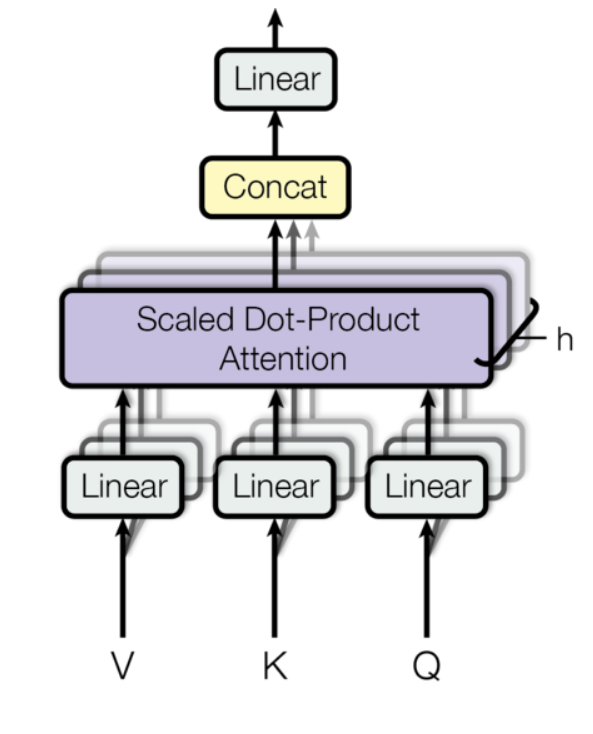

La imagen arriba muestra que tenemos que ingresar a nuestra attention nuestras tres matrices de value, key, y query. Las capas Linear hacen referencia a nuestras matrices de proyección. "h" hace referencia al número de funciones attention que utilicemos, a esto le llamamos atención multi-headed. Lo veremos abajo.

Obtenemos los scores que resultan ser una matriz cuadrada. La podemos interpretar como una matriz que da pesos para cada palabra con respecto a las demás palabras donde en la diagonal tenemos la comparación entre mismas palabras.

In [8]:
scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
scores

tensor([[ 94.5383,  99.2352,  97.2765],
        [ 99.2058, 104.1366, 102.0788],
        [ 97.2091, 102.0398, 100.0245]])

Aplicamos la función softmax sobre la última dimensión (las columnas), en este caso hablamos de que a cada fila les vamos a aplicar la softmax. Vemos que al final los valores de todas las filas suman 1.

In [9]:
p_attn = F.softmax(scores, dim = -1)
p_attn

tensor([[0.0079, 0.8694, 0.1226],
        [0.0064, 0.8811, 0.1125],
        [0.0070, 0.8762, 0.1168]])

Finalmente, multiplicamos nuestra matriz `p_attn` con nuetra matriz de `values` para crear nuestra matriz `Z` que pasará a la feed forward neural network. `Z` tiene forma (3,768), es decir, la misma que nuestro embedding que ingresamos originalmente.

In [10]:
z = torch.matmul(p_attn, value)
z.shape

torch.Size([3, 768])

Lo que estamos haciendo es es codificando la siguiente ecuación: 
$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}\right) V
$$
Concretemos todo en una única función llamada `attention`.
Nota: la función de arriba es una función de atención de producto punto escalado. No sería escalado si no colocaramos el $\sqrt{d_{k}}$. 



In [11]:
def attention(query, key, value):
  "Obtener 'Scaled Dot Product Attention'"

  d_k = query.shape[-1]

  scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
  attn = F.softmax(scores, dim = -1)
  z = torch.matmul(attn, value)

  return z, attn

In [12]:
attention(query, key, value)

(tensor([[1.9599, 1.9514, 1.9623,  ..., 1.8916, 1.9233, 1.9816],
         [1.9606, 1.9521, 1.9629,  ..., 1.8923, 1.9234, 1.9821],
         [1.9603, 1.9518, 1.9627,  ..., 1.8920, 1.9234, 1.9819]]),
 tensor([[0.0079, 0.8694, 0.1226],
         [0.0064, 0.8811, 0.1125],
         [0.0070, 0.8762, 0.1168]]))

## 2. Atención multi-headed

"La atención de múltiples cabezales permite que el modelo atienda de manera conjunta la información de diferentes subespacios de representación en diferentes posiciones. Con un solo cabezal de atención, el promedio lo inhibe." - [Harvard NLP](https://nlp.seas.harvard.edu/2018/04/03/attention.html)

La traducción la hice yo pero aún así no parece español. Segunda traducción: si permitimos que diferentes cabezas (manera presumida de decir capas) de atención que comiencen su aprendizaje desde diferentes puntos (inicializamos los pesos aleatoriamente en todas las cabezas) entonces cada una llegará a diferentes conclusiones de las otras. Es como juntar ocho personas con experiencias diferentes de la vida piensen acerca de un mismo problema, cada quien desde su perspectiva, y al final juntamos las soluciones brindadas. Te aseguro que este metodo será mucho mejor a que si una sola persona piensa la solución al problema. Ese es el concepto de la atención multi-headed.

Ahora, la ecuación es:

\begin{array}{l}
\text { MultiHead }(Q, K, V)=\text { Concat }\left(\text { head }_{1}, \ldots, \text { head }_{\mathrm{h}}\right) W^{O} \\
\text { donde head }_{\mathrm{i}}=\text { Attention }\left(Q W_{i}^{Q}, K W_{i}^{K}, V W_{i}^{V}\right)
\end{array}

La ecuación nos indica que para crear una atención multi-headed necesitamos ingresar nuestras matrices Query, Key y Value; estas entrarán a cada una de nuestas cabezas attention multiplicando las matrices de proyección $W$. Como vimos arriba, cada attention nos va a regresar un tensor que tendrá las dimensiones del embedding original que ingresamos (768 arriba). En este caso no será será así. Ahora, cada attention nos regresará un tensor de dimensión $768 / heads$. En bert $heads = 12$ entonces tenemos que cada attention regresará un tensor de dimensión 64. 

¿Por qué menos dimensiones? Porque vamos a concatener (pegar) los tensores lado a lado de forma que tendremos las $heads * 64 = 768$ dimensiones del embedding original. Teóricamente, como estamos calculando tensores más pequeños, el costo computacional debe ser similar al de calcular una sola cabeza más grande.

Notar que estamos multiplicando nuestra concatenación por $W^{O}$. Estamos asignando pesos para que indicarán la mejor forma de acomodar la concatenación.

Vayamos escribiendo paso a paso esta ecuación en código de pytorch.

Primero notar que nuestras matrices Query, Key y Values tienen forma `(n_palabras, d_modelo)` donde `n_palabras` son el número de palabras que estamos ingresando y `d_modelo` es el tamaño de la dimensión de nuestro emebdding entrante (y, por lo tanto, saliente).

In [13]:
d_modelo =  768
n_palabras = query.shape[0]

Ahora creamos una función `nn.Linear` que es equivalente a $y = xA^T + b$ donde X es una matriz de proyección. En otras palabras, equivale a lo que escribimos arriba manualmente pero ahora hecho con operaciones en la libreria `nn` de pytorch.

Veremos que el resultado serán tensores de forma (3, 768) porque tenemos tres palabras y un embedding de 768 dimensiones.

In [14]:
linear_q = nn.Linear(in_features=d_modelo, out_features=d_modelo)
linear_k = nn.Linear(in_features=d_modelo, out_features=d_modelo)
linear_v = nn.Linear(in_features=d_modelo, out_features=d_modelo)

linear_q(embedding_palabras).shape

torch.Size([3, 768])

In [15]:
query = linear_q(embedding_palabras)
key = linear_k(embedding_palabras)
value = linear_v(embedding_palabras)

Hasta este punto todas las dimensones siguen iguales que con una sola cabeza. Ahora comienza el proceso de crear las múltiples cabezas. 

1. Vamos a cambiar la forma de nuestras matrices a `(n_palabras, cabezas, d_modelo / cabezas)`. En este caso el resultado es `(3, 12, 64)`. 

In [16]:
query = query.view(-1, 12, 64)
key = key.view(-1, 12, 64)
value = value.view(-1, 12, 64)

In [17]:
query.shape

torch.Size([3, 12, 64])

Lo que hicimos fue crear para cada palabra una matriz de (12, 64). Esto equivale a tener por cada palabra 12 representaciones diferentes (las cabezass) para 64 valores de un embedding. En otras palabras, ¡tenemos 12 embeddings de 64 dimensiones por palabra! 
2. Ahora vamos a transponer estas matrices para cada una de nuestras palabras, es lo mismo que hicimos con una sola cabeza.

In [18]:
query = query.transpose(1,2)
key = key.transpose(1,2)
value = value.transpose(1,2)

In [19]:
query.shape

torch.Size([3, 64, 12])

3. Apliquemos nuestra función de atención que creamos hace rato. Nos va a retornar nuestra `z` que tendrá las mismas dimensiones de lo que ingresamos y nuestro valor `attn`.

In [20]:
z, attn = attention(query, key, value)

In [21]:
z.shape, attn.shape

(torch.Size([3, 64, 12]), torch.Size([3, 64, 64]))

4. Vamos a concatenar nuestros resultados para obtener un embedding del tamaño original: (3, 768). Primero transponemos a la forma original. Por cuestiones de memoria, es buena práctica usar la función `contiguous()` después de transponer.


In [22]:
z = z.transpose(1,2).contiguous()

In [23]:
z.shape

torch.Size([3, 12, 64])

Ahora usamos view para regresar a la forma original y listo.

In [24]:
z = z.view(n_palabras, -1)

In [25]:
z.shape

torch.Size([3, 768])

Casi acabamos...
5. Ahora solo multiplicamos el acodo resultante por la matriz $W^{O}$ usando de nuevo una función `nn.Linear`.

In [26]:
linear_w0 = nn.Linear(768, 768)

In [27]:
z = linear_w0(z)

In [28]:
z.shape

torch.Size([3, 768])

In [29]:
class MultiHeadedAttention(nn.Module):
  def __init__(self, h, d_modelo):
    "Se reciben el número de cabezas (h) y las dimensiones de cada cabeza (d)"
    super(MultiHeadedAttention, self).__init__()
    self.h = h
    self.d_modelo = d_modelo
    self.linear_w0 = nn.Linear(d_modelo, d_modelo)

  def forward(self, query, key, value):
    "Definimos el grafo a seguir."
    query = query.view(-1, self.h, int(self.d_modelo / self.h)).transpose(1,2)
    key = key.view(-1, self.h, int(self.d_modelo / self.h)).transpose(1,2)
    value = value.view(-1, self.h, int(self.d_modelo / self.h)).transpose(1,2)

    z, _ = attention(query, key, value)

    z = z.transpose(1,2).contiguous().view(n_palabras, -1)

    z = linear_w0(z)

    return z

Para probar nuestro `Module` creamos de nuevo nuestras matrices Query, Key y Value.

In [30]:
query = linear_q(embedding_palabras)
key = linear_k(embedding_palabras)
value = linear_v(embedding_palabras)

In [31]:
multiHeadedAttention = MultiHeadedAttention(h = 12, d_modelo = d_modelo)

In [32]:
multiHeadedAttention

MultiHeadedAttention(
  (linear_w0): Linear(in_features=768, out_features=768, bias=True)
)

Obtendremos un tensor con el mismo resultado que obtuvimos creando la multi-headed attention paso a paso.

In [33]:
z_con_modulo = multiHeadedAttention(query, key, value) 

In [34]:
assert z_con_modulo.detach().numpy().all() == z.detach().numpy().all()

Hay algo muy interesante y confuso. Si corremos nuestra instancia `MultiHeadedAttention` que creamos, vamos a ver que únicamene estamos agregando la matriz de pesos `W_0`, nada más eso. Los pesos de las matrices de proyección para Query, Key y Value siguen siendo las mismas. Mismo número de pesos. Por esta razón creo que la magia de los multi-headed attentions está en la matriz que decide la mejor forma de acomoda nuestro embedding resultante, `W_0`. 

Es también por esta misma razón que podemos esperar que una multi-headed attention no sea mucho más pesado computacionalmente que una attention de una sola cabeza.